In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scripts.plot import *
from scripts.baseline_prob_label_spreading import *
from scripts.probabilistic_label_spreading import prob_label_spreading
import time
start_time = time.time()

plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)

# 1 Performance on training vs. test set

In [2]:
if not os.path.exists("results/test_and_training_performance.csv"):
    dataset_name = "CIFAR10-H" # "EMNIST", "TinyImageNet"
    path_to_dataset = "data/prob_data/"+ dataset_name + "/" + dataset_name + ".pkl"

    df = pd.read_pickle(path_to_dataset)
    classes = list(set(df["label"]))

    # fix parameters
    k = 20
    n_data = "all"
    data_space = "CLIP_UMAP_20"
    prob_label_column = "prob_label" # _effnetb0

    alphas = [0.1, 0.5, 0.9, 0.99] # 
    budgets = [0.001,0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0] # 

    alpha_ticker = []
    budget_ticker = []
    training_accuracy_ticker = []
    training_rmse_ticker = []
    test_accuracy_ticker = []
    test_rmse_ticker = []
    n_samples_ticker = []

    train_split = np.random.choice(df.index, size= int(0.8*len(df)), replace=False)
    train_mask = df.index.isin(train_split)  # Boolean mask for training data
    test_mask = ~train_mask  # Complement mask for test data

    for alpha in alphas:
        for budget in budgets:
            n_samples = int(budget*len(df))
            results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples, train_split)
            alpha_ticker.append(alpha)
            budget_ticker.append(budget)
            n_samples_ticker.append(n_samples)
            
            train_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[train_mask, "p_hat"].to_list()), np.array(processed_data.loc[train_mask, prob_label_column].to_list()))
            train_acc = len(processed_data.loc[train_mask].query("most_probable_class == prediction"))/len(processed_data.loc[train_mask])

            test_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[test_mask, "p_hat"].to_list()), np.array(processed_data.loc[test_mask, prob_label_column].to_list()))
            test_acc = len(processed_data.loc[test_mask].query("most_probable_class == prediction"))/len(processed_data.loc[test_mask])

            training_accuracy_ticker.append(train_acc)
            training_rmse_ticker.append(train_rmse)
            test_accuracy_ticker.append(test_acc)
            test_rmse_ticker.append(test_rmse)
            
    performance_results = pd.DataFrame({"alpha": alpha_ticker, "budget": budget_ticker, "n_samples": n_samples_ticker, "training_accuracy": training_accuracy_ticker, "training_rmse": training_rmse_ticker, "test_accuracy": test_accuracy_ticker, "test_rmse": test_rmse_ticker})

    performance_results.to_csv("results/test_and_training_performance.csv")

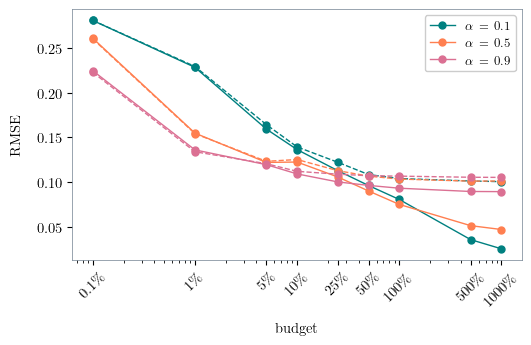

In [3]:
if os.path.exists("results/test_and_training_performance.csv"):
    performance_results = pd.read_csv("results/test_and_training_performance.csv")

# plot performance on training and test data depending on alpha and budget

fig = plt.figure()
ax = plt.gca()

alphas = performance_results["alpha"].unique()

for alpha in alphas:
    if alpha == 0.99:
        continue
    X = performance_results.query("alpha == @alpha")["budget"] * 100
    Y_1 = performance_results.query("alpha == @alpha")["training_rmse"]
    Y_2 = performance_results.query("alpha == @alpha")["test_rmse"]
    line, = ax.plot(X, Y_1, label = f"$\\alpha\,=\,{alpha}$", marker = "o", ms = 5)
    ax.plot(X, Y_2, ls = "dashed", color=line.get_color(), marker = "o", ms = 5)
    
    
    
ax.set_xlabel("budget")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}\\%' if x < 1 else f'{int(x)}\\%'))

ax.set_ylabel("RMSE")
ax.legend()
plt.xticks(X, rotation = 45)

plt.savefig("plots/test_vs_training_rmse.png")

plt.show()

# 2 Performance Estimation via a test dataset

In [4]:
dataset_name = "CIFAR10-H" # "EMNIST", "TinyImageNet"
path_to_dataset = "data/prob_data/"+ dataset_name + "/" + dataset_name + ".pkl"

df = pd.read_pickle(path_to_dataset)
classes = list(set(df["label"]))

# run the algorithm once
k = 20
n_data = "all"
data_space = "CLIP_UMAP_20"
prob_label_column = "prob_label" # _effnetb0
alpha = 0.9
n_samples = 1000

train_split = np.random.choice(df.index, size= int(0.8*len(df)), replace=False)

results, processed_data = prob_label_spreading(dataset_name, df, data_space, prob_label_column, n_data, k, alpha, n_samples, train_split)

In [5]:
train_mask = df.index.isin(train_split)  # Boolean mask for training data
test_mask = ~train_mask  # Complement mask for test data

train_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[train_mask, "p_hat"].to_list()), np.array(processed_data.loc[train_mask, prob_label_column].to_list()))
train_acc = len(processed_data.loc[train_mask].query("most_probable_class == prediction"))/len(processed_data.loc[train_mask])

test_rmse = sklearn.metrics.root_mean_squared_error(np.array(processed_data.loc[test_mask, "p_hat"].to_list()), np.array(processed_data.loc[test_mask, prob_label_column].to_list()))
test_acc = len(processed_data.loc[test_mask].query("most_probable_class == prediction"))/len(processed_data.loc[test_mask])

print("RMSE on training data: %.4f"%train_rmse, " RMSE on test data: %.4f"%test_rmse)
print("Accuracy on training data: %.4f"%train_acc, " Accuracy on test data: %.4f"%test_acc)

RMSE on training data: 0.1106  RMSE on test data: 0.1097
Accuracy on training data: 0.8936  Accuracy on test data: 0.9025


In [10]:
# perform crowdsourcing on test dataset to obtain estimated prob. labels
# we can simply use PLS with alpha = 0 for this task and filter on the test data for drawing samples.

prob_labels = np.array(processed_data.loc[test_mask][prob_label_column].to_list())
estimations = np.array(processed_data.loc[test_mask]["p_hat"].to_list())

actual_rmse = sklearn.metrics.root_mean_squared_error(estimations, prob_labels)
actual_acc = len(processed_data.loc[test_mask].query("most_probable_class == prediction"))/len(processed_data.loc[test_mask])

In [11]:
def histogram_estimates_for_test_data(testdata, prob_label_column, n_labels_per_datapoint):
    
    labels = np.array([np.random.choice(classes, size=n_labels_per_datapoint, p=prob) for prob in testdata[prob_label_column]])
    histogram_estimates = np.apply_along_axis(lambda x: np.bincount(x, minlength=len(classes)), axis=1, arr=labels)
    histogram_estimates = histogram_estimates / histogram_estimates.sum(axis=1, keepdims=True)
    
    return histogram_estimates

n_labels_per_datapoint = 10
histogram_estimates = histogram_estimates_for_test_data(processed_data.loc[test_mask], prob_label_column, n_labels_per_datapoint)

estimated_rmse = sklearn.metrics.root_mean_squared_error(estimations, histogram_estimates)
estimated_acc = np.sum( estimations.argmax(axis = 1) == histogram_estimates.argmax(axis = 1)) / estimations.shape[0]

In [12]:
def performance_estimation(testdata, prob_label_column, n_test_data, n_labels_per_datapoint):
    if n_test_data > len(testdata):
        print("n_test_data is larger than the number of test data points.")
        return np.nan, np.nan
    else:
        testdata = testdata.sample(n = n_test_data)
        histogram_estimates = histogram_estimates_for_test_data(testdata, prob_label_column, n_labels_per_datapoint)
        estimations = np.array(testdata["p_hat"].to_list())
        rmse = sklearn.metrics.root_mean_squared_error(estimations, histogram_estimates)
        acc = np.sum( estimations.argmax(axis = 1) == histogram_estimates.argmax(axis = 1)) / estimations.shape[0]
        return rmse, acc
    
n_test_data = 10
n_labels_per_datapoint = 10
estimated_rmse, estimated_acc = performance_estimation(processed_data.loc[test_mask], prob_label_column, n_test_data, n_labels_per_datapoint)

estimated_rmse

0.10773832481418522

In [ ]:
testdata_sizes = [10, 25, 50, 100, 200, 500, 1000, 2000]
n_labels = [1, 2, 3, 4, 5, 7, 10]

multiple_runs = 10

results_list = []

for size in testdata_sizes:
    for n_label in n_labels:
        for _ in range(multiple_runs):
            rmse, acc = performance_estimation(processed_data.loc[test_mask], prob_label_column, size, n_label)
            results_list.append({
                "testdata_size": size,
                "n_labels_per_datapoint": n_label,
                "rmse": rmse,
                "accuracy": acc
            })

results_df = pd.DataFrame(results_list)

# Group by the parameter combinations and aggregate over the multiple runs
aggregated_results = results_df.groupby(["testdata_size", "n_labels_per_datapoint"]).agg(
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    accuracy_mean=("accuracy", "mean"),
    accuracy_std=("accuracy", "std")
).reset_index()

In [14]:
aggregated_results.head()

,testdata_size,n_labels_per_datapoint,rmse_mean,rmse_std,accuracy_mean,accuracy_std
0,10,1,0.082904,0.040006,0.89,0.099443
1,10,2,0.087777,0.037991,0.87,0.094868
2,10,3,0.088407,0.040922,0.90,0.115470
3,10,4,0.076871,0.033113,0.92,0.078881
4,10,5,0.085474,0.038725,0.91,0.087560


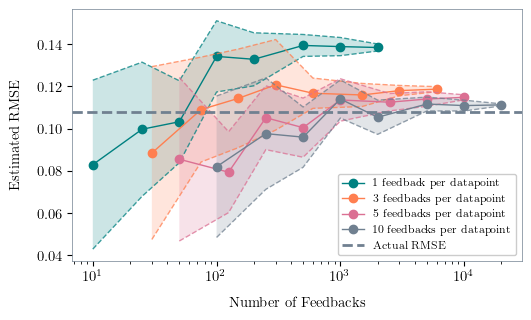

In [16]:
fig, ax = plt.subplots()

for n_label in [1, 3, 5, 10]:  # n_labels
    subset = aggregated_results[aggregated_results["n_labels_per_datapoint"] == n_label]
    X = subset["testdata_size"] * n_label
    Y = subset["rmse_mean"]
    Y_std = subset["rmse_std"]
    
    label = f"{n_label} feedback per datapoint" if n_label == 1 else f"{n_label} feedbacks per datapoint"
    ax.plot(X, Y, marker="o", label=label)
    ax.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2, edgecolor='none')
    ax.plot(X, Y - Y_std, alpha=0.75, linestyle='--', color=ax.get_lines()[-1].get_color())
    ax.plot(X, Y + Y_std, alpha=0.75, linestyle='--', color=ax.get_lines()[-1].get_color())

ax.set_xlabel("Number of Feedbacks")
ax.set_ylabel("Estimated RMSE")
ax.set_xscale("log")
ax.axhline(y=actual_rmse, color="slategrey", linestyle="--", lw=2, label="Actual RMSE")
ax.legend(prop={'size': 8})

#plt.title("Est. RMSE for Different Numbers of Labels per Datapoint and Test Data Sizes")

plt.savefig(f"plots/estimated_rmse_{dataset_name}.png")
plt.show()

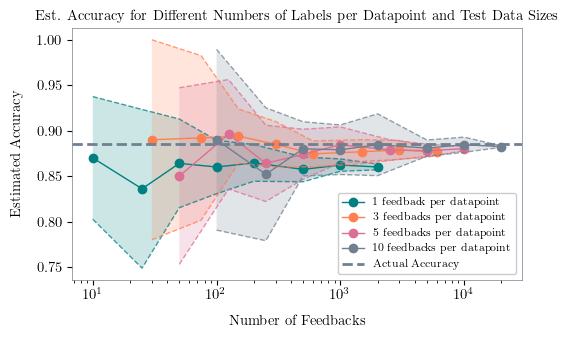

In [12]:
fig, ax = plt.subplots()

for n_label in [1, 3, 5, 10]:  # n_labels
    subset = aggregated_results[aggregated_results["n_labels_per_datapoint"] == n_label]
    X = subset["testdata_size"] * n_label
    Y = subset["accuracy_mean"]
    Y_std = subset["accuracy_std"]
    
    label = f"{n_label} feedback per datapoint" if n_label == 1 else f"{n_label} feedbacks per datapoint"
    ax.plot(X, Y, marker="o", label=label)
    ax.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2, edgecolor='none')
    ax.plot(X, Y - Y_std, alpha=0.75, linestyle='--', color=ax.get_lines()[-1].get_color())
    ax.plot(X, Y + Y_std, alpha=0.75, linestyle='--', color=ax.get_lines()[-1].get_color())

ax.set_xlabel("Number of Feedbacks")
ax.set_ylabel("Estimated Accuracy")
ax.set_xscale("log")
ax.axhline(y=actual_acc, color="slategrey", linestyle="--", lw=2, label="Actual Accuracy")
ax.legend(prop={'size': 8})

plt.title("Est. Accuracy for Different Numbers of Labels per Datapoint and Test Data Sizes")

plt.savefig(f"plots/estimated_acc_{dataset_name}.png")
plt.show()